## Logistic Regression
### 背景：
逻辑回归是经典的机器学习分类模型，凭借可解释性强等优点，现在仍是主流分类问题解决方案。

### 目的：
1. 了解分类问题常用评价指标，并理解其局限
2. 掌握一种二分类threshold确定方法

### 算法原理：
#### 二分类
狭义上，逻辑回归是二分类机器学习模型，首先对样本特征做线性回归，并将线性回归结果输入Sigmoid函数（激活函数），来预测样本为positive的概率；
若预测概率大于threshold，则标记样本为positive，反之为negative。
#### 多分类
经过推广，Logistic Regression也可以解决多分类问题，解决方案有两种：
1. 组合使用多个二分类Logistic Regression模型，依次分类样本是否属于某个类别
2. 推广为多元Logistic Regression模型，使用Softmax作为激活函数，直接根据样本特征的线性回归结果计算样本属于每一类别的概率，取概率最高的类别作为样本的预测概率。


### 损失函数
不论是二分类还是多分类问题，Logistic Regression模型训练的损失函数都是cross-entropy。


### 模型评价指标
分类问题的常用模型评价指标，由简单到复杂排列有：
1. Accuracy
2. Precision, Recall
3. F1_score, F2_score
4. ROC/AUC

#### 1. Accuracy
准确率是最简单的分类模型评估指标，它等于分类正确样本数除以数据集样本总数。**当遇到总体类别比例极不均衡的场景时，accuracy会存在明显缺陷，此时占比大的类别会成为影响accuracy的主要因素。**
例如：在奢侈品用户分类任务中，奢侈品用户只占总体人口比例的极少数，所以就算模型不做任何预测，直接将所有样本都标记为非奢用户也能取得很好地accuracy，但此时对任务真实需求的贡献为零。
这促使后续更为合理的Precision和Recall分类模型评估指标出现。

#### 2. Precision, Recall
Precision和Recall基于混淆矩阵(confusion matrix)计算，Precision表示所有模型标记为positive的样本中，实际标签也为positive的样本比例，即真阳率；Recall表示所有标签为positive的样本中，模型标记为positive的样本比例。
Precision与Recall是一对矛盾的度量，为了综合考虑Precision与Recall的性能，常用F1_score或F2_score进行度量。

#### 3. F1_score, F2_score
F1_score是Precision与Recall的调和平均数，F2_score则是Precision与Recall的加权调和平均数。

#### 4. ROC/AUC


### 初始化

In [11]:
# 环境初始化
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"  # 执行全部行输出命令

In [12]:
# 加载数据
df_o = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
df_o.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'category']
df_o.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   category      150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


<ipython-input-12-1820ea9b98a1>:4: FutureWarning: null_counts is deprecated. Use show_counts instead
  df_o.info(verbose=True, null_counts=True)


In [13]:
df = df_o.iloc[50:,:]
df_nf = df.drop(columns='category')
df_nf.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,100.000000,100.000000,100.000000,100.000000
mean,6.262000,2.872000,4.906000,1.676000
std,0.662834,0.332751,0.825578,0.424769
min,4.900000,2.000000,3.000000,1.000000
25%,5.800000,2.700000,4.375000,1.300000
50%,6.300000,2.900000,4.900000,1.600000
75%,6.700000,3.025000,5.525000,2.000000
max,7.900000,3.800000,6.900000,2.500000


### 数据预处理

In [14]:
X, y = df.drop(columns='category').values, df['category'].values.reshape(len(df['category']),1)
print(X.shape); print(type(X))
print(y.shape); print(type(y))


(100, 4)
<class 'numpy.ndarray'>
(100, 1)
<class 'numpy.ndarray'>


In [15]:
#
from sklearn.preprocessing import StandardScaler
standardized = StandardScaler()
X_std = standardized.fit_transform(X)


In [16]:
# 改造数据自标签，为判定手写数字是否是5的二分类问题
y_IV = [1 if i=='Iris-versicolor' else 0 for i in y]
y_IV = np.array(y_IV).reshape(len(y_IV),1)


In [17]:
# 数据集分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_std, y_IV, test_size=0.2, random_state=0)

# def data_split(data, test_ratio=0.2, val_ratio=0, index=0):
#     if isinstance(index,int): index = np.random.choice(range(len(data)), size=len(data), replace=False)
#     train_index = index[:int(len(data)*(1-val_ratio-test_ratio))]
#     val_index = index[int(len(data)*(1-val_ratio-test_ratio)):int(len(data)*(1-test_ratio))]
#     test_index = index[int(len(data)*(1-test_ratio)):]
#     return data[train_index], data[test_index], data[val_index], index
# #
# y_train,y_test,_,_ = data_split(y_IV,test_ratio=0.2)
# X_train,X_test,_,X_index = data_split(X_std,test_ratio=0.2)


### 模型：
sigmoid(x) = $\frac{1}{1+e^{-x}}$

$z(X,\theta) = X_{m{\times}n}W_{1{\times}n}^T + b$

$p(X,\theta) = sigmoid(z) = \frac{1}{1+e^{-(X_{m{\times}n}W_{1{\times}n}^T + b)}}$

$y_{hat} = \begin{cases}
1, &  p(X,\theta)>= 0.5\\[2ex]
0, &  p(X,\theta)< 0.5
\end{cases}$


### 损失函数：
$loss = -{\frac{1}{m}}\sum_{i=1}^{m}y^ilog(\frac{1}{1+e^{-(X_{1{\times}n}^iW_{1{\times}n}^T + b)}}) + (1-y^i)log(1-\frac{1}{1+e^{-(X_{1{\times}n}^iW_{1{\times}n}^T + b)}})$
$= -{\frac{1}{m}}(y_{m\times{1}}^Tlog(\frac{1}{1+e^{-(X_{m{\times}n}W_{1{\times}n}^T + b)}}) + (1-y_{m\times{1}}^T)log(1-\frac{1}{1+e^{-(X_{m{\times}n}W_{1{\times}n}^T + b)}}))$

### 梯度下降：
$\frac{\partial loss}{\partial W} = {\frac{1}{m}}[(\frac{1}{1+e^{-(X_{m{\times}n}W_{1{\times}n}^T + b)}})^T-y_{m\times{1}}^T]X_{m{\times}n}$
$\frac{\partial loss}{\partial b} = {\frac{1}{m}}\sum_{i=1}^m[(\frac{1}{1+e^{-(X_{m{\times}n}W_{1{\times}n}^T + b)}})^T - y_{1\times{m}}^T]$

### 正则化
正则化的方法与MSE一样，为在cross-entropy后添加L1或L2惩罚项


第一层线性回归的



In [18]:
# 模型定义
def sigmoid(y_hat):
    return 1/(1 + np.exp(-y_hat))

def LinReg_train(X,y,num_epochs,lr,lam,patient):
    num_sample,num_feature = X.shape
    # 初始化
    W_rec = [np.random.normal(0,1,(1,num_feature))]
    b_rec = [0]
    loss = [0]              # 每迭代损失函数值记录器
    loss_diff = [np.inf]    # 每迭代损失函数下降步长记录器
    j = 0                   # patient消耗程度记录器
    # 训练
    for i in range(num_epochs):
        W = W_rec[i]; b = b_rec[i]
        p_hat = sigmoid(X.dot(W.T)+b)
        # MSE & L2
        # ls = -(y.T.dot(np.log(p_hat)) + (1-y.T).dot(np.log(1-p_hat)))/num_sample + (lam/2)*W.dot(W.T)
        ls = -(y.T.dot(np.log(p_hat)) + (1-y.T).dot(np.log(1-p_hat)))/num_sample
        loss.append(float(ls))
        # 提前终止
        loss_diff.append(float(abs(loss[-1]-loss[-2])))
        if loss_diff[-1]>=min(loss_diff[:-1]): j+=1
        if j==patient:
            minLoss_index = loss.index(min(loss[1:]))
            return loss[1:minLoss_index+1], W_rec[minLoss_index-1], b_rec[minLoss_index-1]
        # 优化（GradientDescent & L2）
        # W = W-lr*(p_hat.T-y.T).dot(X)/num_sample - lr*lam*W
        W = W-lr*(p_hat.T-y.T).dot(X)/num_sample
        b = b-lr*np.mean(p_hat.T-y.T)
        W_rec.append(W); b_rec.append(b)
    return loss[1:], W_rec[-1], b_rec[-1]

# 预测
def LinReg_price(X,y,W,b):
    num_sample,_ = X.shape
    p_hat = sigmoid(X.dot(W.T)+b)
    y_hat = [1 if i>=0.5 else 0for i in p_hat]
    # MSE
    ls = -(y.T.dot(np.log(p_hat)) + (1-y.T).dot(np.log(1-p_hat)))/num_sample
    return y_hat, ls

In [19]:
# 超参数定义
num_epochs =1000 #训练迭代次数
lr = 0.03           #学习率
lam = 3            #正则化惩罚系数
patient = 10        #提前停止容忍度
Num = 1          #重复试验次数

0.11830587439663717

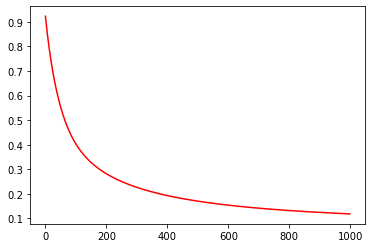

In [20]:
#
loss_CV,W,b = LinReg_train(X_train,y_train,num_epochs,lr,lam,patient)
loss_CV[-1]

# 代价函数值收敛趋势图
plt.plot(np.arange(len(loss_CV)-1), loss_CV[1:], 'r')
plt.show()

In [21]:
y_hat, ls = LinReg_price(X_test,y_test,W,b)
ls


array([[0.13877469]])